In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras import (models, initializers as init, 
                              layers, backend as K, regularizers as reg,
                             optimizers as opt, losses, metrics)

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
dataset = np.concatenate([x_train, x_test], axis=0)
dataset = np.expand_dims(dataset, -1).astype("float32")/255

In [5]:
BATCH_SIZE=64
dataset = tf.data.Dataset.from_tensor_slices(dataset)
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [6]:
NOISE_DIM = 128
generator = models.Sequential([
    layers.InputLayer(input_shape=NOISE_DIM),
    layers.Dense(7*7*128),
    layers.Reshape((7,7,128)),
    layers.Conv2DTranspose(128, 3, strides=2, activation="LeakyReLU", padding="same"),
    layers.Conv2DTranspose(64, 3, strides=2, activation="LeakyReLU", padding="same"),
    layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        577       
 ranspose)                                                       
                                                        

In [7]:
discriminator = models.Sequential([
  layers.InputLayer(input_shape=(28, 28, 1)),
  layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
  layers.Conv2D(64, 3, activation="relu", strides=2, padding="same"),
  layers.Flatten(),
  layers.Dense(64, activation="relu"),
  layers.Dropout(0.2),
  layers.Dense(1, activation="sigmoid")
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 128)       1280      
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          73792     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                200768    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 275,905
Trainable params: 275,905
Non-tr

In [23]:
optimizerG = opt.Adam(learning_rate=0.00003, beta_1=0.5)
optimizerD = opt.Adam(learning_rate=0.00003, beta_1=0.5)

# binary classifier (real or fake)
lossFn = losses.BinaryCrossentropy(from_logits=True)

# accuracy metric
gAccMetric = metrics.BinaryAccuracy()
dAccMetric = metrics.BinaryAccuracy()

In [28]:
@tf.function
def trainDStep(data):
    batch_size = tf.shape(data)[0]
    noise = tf.random.normal(shape=(batch_size, NOISE_DIM))

    # concatenate the real and fake labels
    y_true = tf.concat([
      # the original data is real, labeled with 1
      tf.ones(batch_size, 1),
      # the forged data is fake, labeled with 0
      tf.zeros(batch_size, 1)
    ], axis=0)

    with tf.GradientTape() as tape:
        # generate samples
        fake = generator(noise)
        # concatenate real data and fake data
        x = tf.concat([data, fake], axis=0)
        # see if the discriminator detects them
        y_pred = discriminator(x)
        discriminatorLoss = lossFn(y_true, y_pred)

    # apply the backward path and update weights
    grads = tape.gradient(discriminatorLoss, discriminator.trainable_weights)
    optimizerD.apply_gradients(zip(grads, discriminator.trainable_weights))

    # report accuracy
    dAccMetric.update_state(y_true, y_pred)

    # return the loss for visualization
    return {
      "discriminator_loss": discriminatorLoss,
      "discriminator_accuracy": dAccMetric.result()
    }

In [29]:
@tf.function
def trainGStep(data):
    batch_size = tf.shape(data)[0]
    noise = tf.random.normal(shape=(batch_size, NOISE_DIM))
    # when training the generator, we want it to maximize the probability that its
    # output is classified as real, remember the min-max game
    y_true = tf.ones(batch_size, 1)

    with tf.GradientTape() as tape:
        y_pred = discriminator(generator(noise))
        generatorLoss = lossFn(y_true, y_pred)

    grads = tape.gradient(generatorLoss, generator.trainable_weights)
    optimizerG.apply_gradients(zip(grads, generator.trainable_weights))

    gAccMetric.update_state(y_true, y_pred)

    return {
      "generator_loss": generatorLoss,
      "generator_accuracy": gAccMetric.result()
    }

In [30]:
def plotImages(model):
    images = model(np.random.normal(size=(81, NOISE_DIM)))

    plt.figure(figsize=(9, 9))

    for i, image in enumerate(images):
        plt.subplot(9,9,i+1)
        plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
        plt.axis('off')

    plt.show();

E:0, Loss G:0.6758, Loss D:0.5319, Acc G:%0.08, Acc D:%99.83


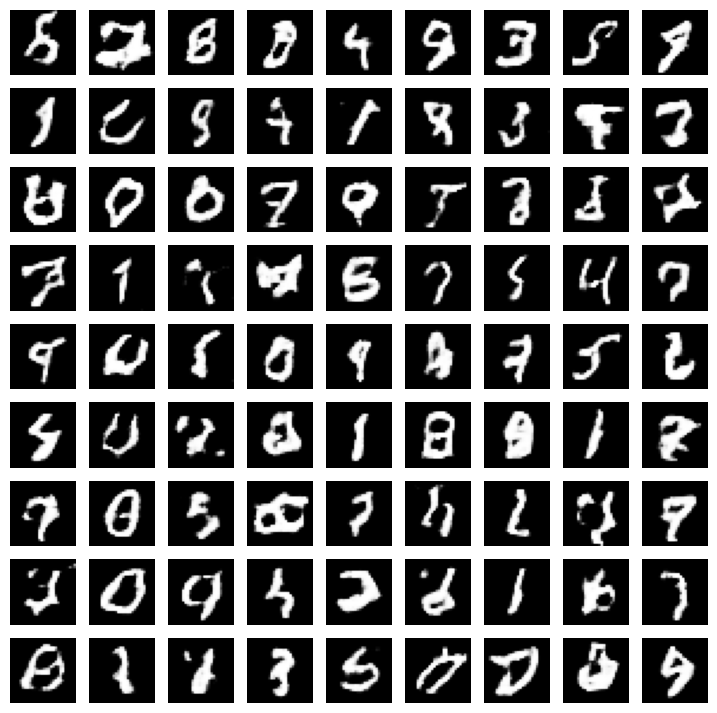

E:1, Loss G:0.6817, Loss D:0.5198, Acc G:%0.15, Acc D:%99.71
E:2, Loss G:0.6827, Loss D:0.5190, Acc G:%0.21, Acc D:%99.62
E:3, Loss G:0.6820, Loss D:0.5187, Acc G:%0.26, Acc D:%99.54
E:4, Loss G:0.6824, Loss D:0.5189, Acc G:%0.31, Acc D:%99.46
E:5, Loss G:0.6822, Loss D:0.5187, Acc G:%0.35, Acc D:%99.39


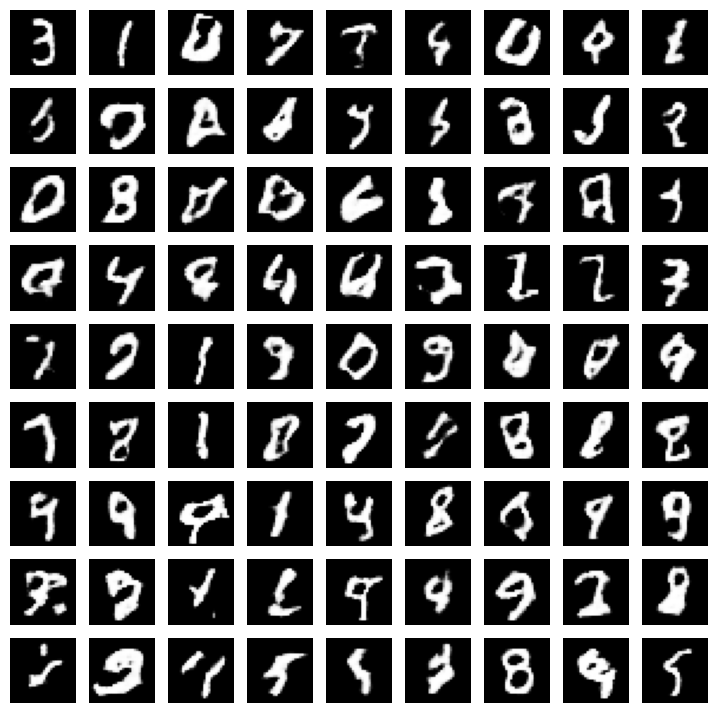

E:6, Loss G:0.6818, Loss D:0.5189, Acc G:%0.39, Acc D:%99.33
E:7, Loss G:0.6822, Loss D:0.5193, Acc G:%0.43, Acc D:%99.26
E:8, Loss G:0.6819, Loss D:0.5194, Acc G:%0.47, Acc D:%99.20
E:9, Loss G:0.6816, Loss D:0.5197, Acc G:%0.51, Acc D:%99.14
E:10, Loss G:0.6814, Loss D:0.5201, Acc G:%0.54, Acc D:%99.08


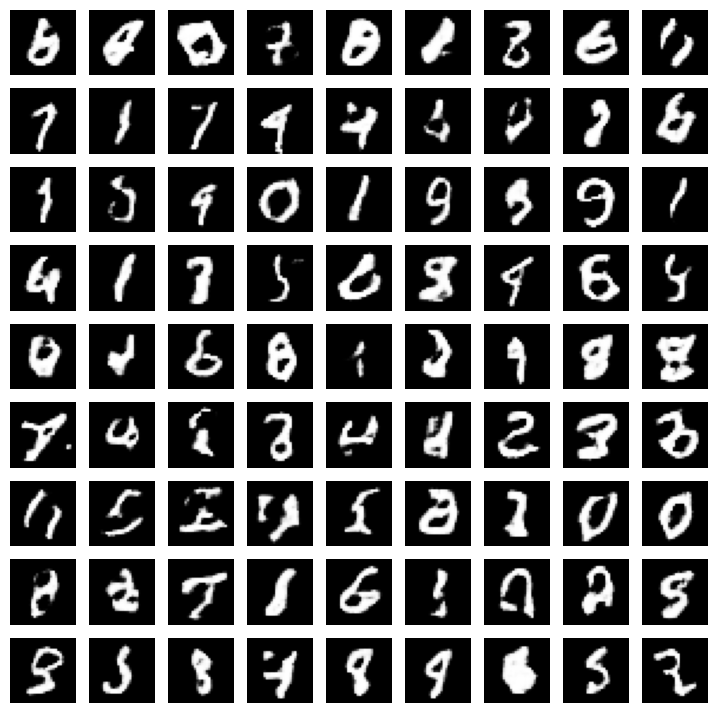

E:11, Loss G:0.6811, Loss D:0.5205, Acc G:%0.58, Acc D:%99.02
E:12, Loss G:0.6810, Loss D:0.5207, Acc G:%0.61, Acc D:%98.97
E:13, Loss G:0.6808, Loss D:0.5213, Acc G:%0.65, Acc D:%98.91
E:14, Loss G:0.6806, Loss D:0.5217, Acc G:%0.68, Acc D:%98.85
E:15, Loss G:0.6795, Loss D:0.5221, Acc G:%0.72, Acc D:%98.80


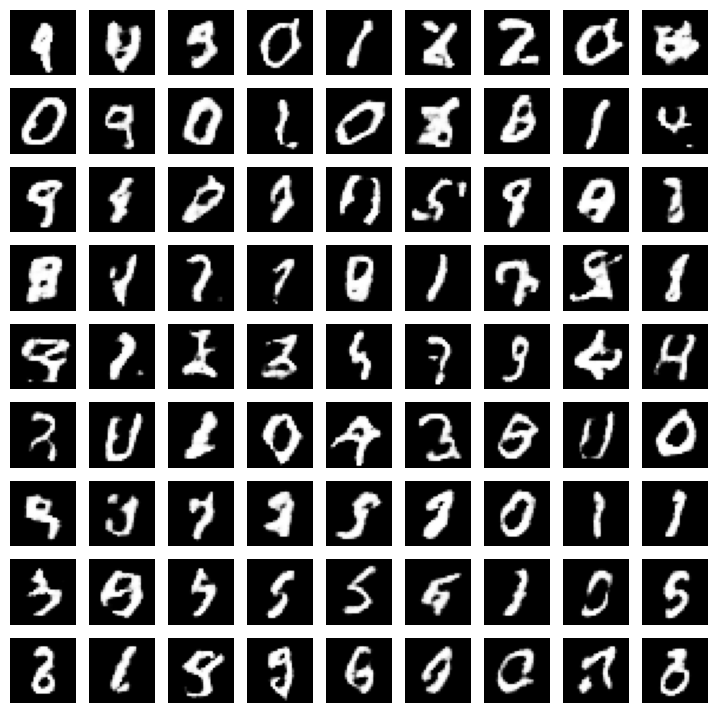

E:16, Loss G:0.6799, Loss D:0.5230, Acc G:%0.75, Acc D:%98.74
E:17, Loss G:0.6793, Loss D:0.5231, Acc G:%0.78, Acc D:%98.69
E:18, Loss G:0.6792, Loss D:0.5240, Acc G:%0.82, Acc D:%98.63
E:19, Loss G:0.6792, Loss D:0.5246, Acc G:%0.85, Acc D:%98.57
E:20, Loss G:0.6785, Loss D:0.5249, Acc G:%0.88, Acc D:%98.52


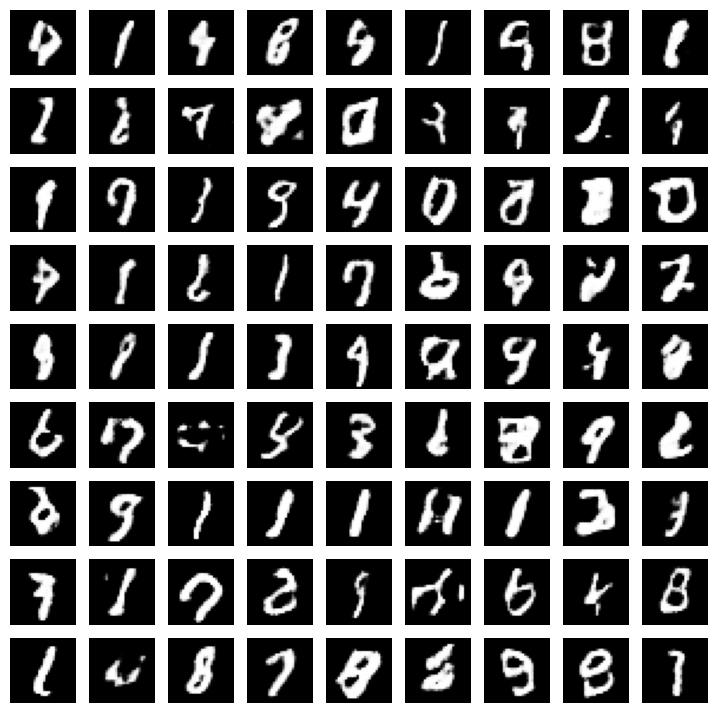

E:21, Loss G:0.6790, Loss D:0.5255, Acc G:%0.92, Acc D:%98.46
E:22, Loss G:0.6785, Loss D:0.5264, Acc G:%0.95, Acc D:%98.40
E:23, Loss G:0.6777, Loss D:0.5263, Acc G:%0.98, Acc D:%98.34
E:24, Loss G:0.6781, Loss D:0.5268, Acc G:%1.01, Acc D:%98.28
E:25, Loss G:0.6780, Loss D:0.5273, Acc G:%1.04, Acc D:%98.22


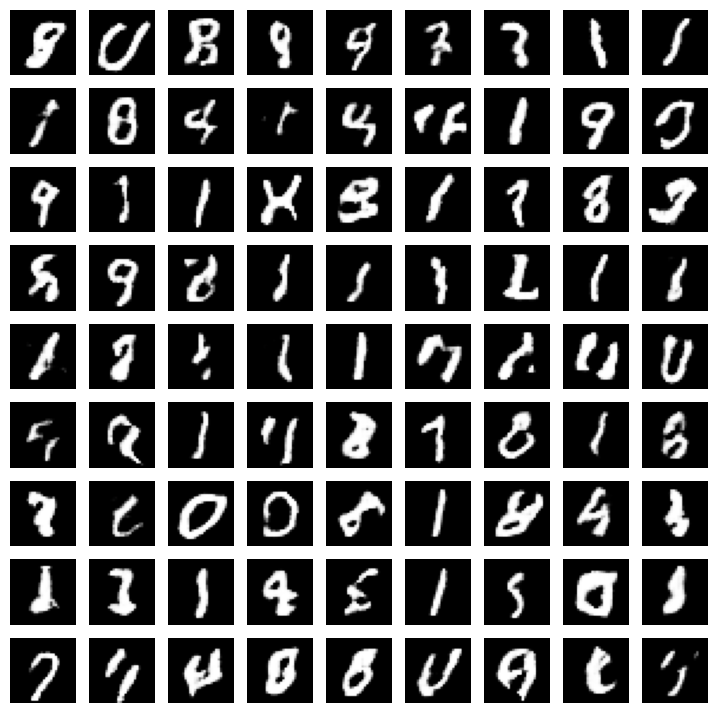

E:26, Loss G:0.6777, Loss D:0.5281, Acc G:%1.06, Acc D:%98.15
E:27, Loss G:0.6779, Loss D:0.5284, Acc G:%1.09, Acc D:%98.09
E:28, Loss G:0.6783, Loss D:0.5293, Acc G:%1.12, Acc D:%98.03
E:29, Loss G:0.6779, Loss D:0.5293, Acc G:%1.14, Acc D:%97.97


In [31]:
for epoch in range(30):

    # accumulate the loss to calculate the average at the end of the epoch
    dLossSum = 0
    gLossSum = 0
    dAccSum = 0
    gAccSum = 0
    cnt = 0

    # loop the dataset one batch at a time
    for batch in dataset:

        # train the discriminator
        # remember you could repeat these 2 lines of code for K times
        dLoss = trainDStep(batch)
        dLossSum += dLoss['discriminator_loss']
        dAccSum += dLoss['discriminator_accuracy']

        # train the generator
        gLoss = trainGStep(batch)
        gLossSum += gLoss['generator_loss']
        gAccSum += gLoss['generator_accuracy']

        # increment the counter
        cnt += 1

    # log the performance
    print("E:{}, Loss G:{:0.4f}, Loss D:{:0.4f}, Acc G:%{:0.2f}, Acc D:%{:0.2f}".format(
        epoch,
        gLossSum/cnt,
        dLossSum/cnt,
        100 * gAccSum/cnt,
        100 * dAccSum/cnt
    ))
    
    if epoch % 5 == 0:
        plotImages(generator)